# Homework 3

## FINM 37500 - 2023

### Madison Rusch, Tim Taylor, Leon Zhang

In [57]:
import pandas as pd
import numpy as np
import datetime
import math
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../cmds')
from binomial import *

# 1. Treasury Futures and Cheapest-to-Deliver

The file `data/fut_bond_data_FVU3_2023-04-21.xlsx` has market data on the following:
* 5-year Treasury future, expiring September 2023
* The specifications of the deliverable treasury bonds

Market quotes are provided on the futures contract and the bond prices. These will be useful for some of the analysis questions, but you do not need them for your models as you are provided a BDT tree which is fit to swaps and caps. See below for more details on this BDT model.

Suppose the present date is `2023-04-21`.

### BDT Model

In this problem you will make use of a BDT modeled binomial tree.

To save you some time, you are provided the parameters of a BDT tree fit to both swaps and caps.
* Use the file `bdt_params_freq52_2023-04-21.xlsx`
* With these $\sigma$ and $\theta$ parameters, you should be able to build a BDT tree with $T=5$ and $dt=1/52$.

#### Note
If interested in how this was done, find the data and files used to get these parameters. In particular, 
* The market quotes interpolated to weekly frequency: `cap_curves_2023-04-21_freq_52.xlsx`.
* The file to estimate the model is `Parameterize BDT.ipynb`.

## 1.1 Trading Bonds

Give brief answers to these based on the market quotes provided,
### 1.1.1
Calculate the 
* gross basis
* carry
* net basis for each bond


In [58]:
# Gross Basis = Price of Bond - Conversion Factor(Futures Price)
filepath = '../data/fut_bond_data_FVU3_2023-04-21.xlsx'
future_data = pd.read_excel(filepath)
future_price = future_data.iloc[1,1]

bond_data = pd.read_excel(filepath, sheet_name='bonds')
# display(bond_data)

bond_data['gross basis'] = bond_data['px_last'] - bond_data['conversion'] * future_price

# Carry = Coupon - Repo Rate
bond_data['carry'] = bond_data['cpn'] - bond_data['repo_reporate']

# Net = Gross - Carry
bond_data['net basis'] = bond_data['gross basis'] - bond_data['carry']
display(bond_data[['ticker', 'gross basis', 'carry', 'net basis']])

,ticker,gross basis,carry,net basis
0,91282CFZ Govt,-0.533577,-0.940,0.406423
1,91282CGC Govt,-0.387684,-0.940,0.552316
2,91282CGH Govt,-0.251620,-1.315,1.063380
3,91282CGP Govt,0.105155,-0.815,0.920155
4,91282CGT Govt,0.194551,-1.190,1.384551



### 1.1.2
Which bond seems most likely to be CTD?


In [59]:
display(bond_data)

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion,gross basis,carry,net basis
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226,-0.533577,-0.940,0.406423
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212,-0.387684,-0.940,0.552316
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058,-0.251620,-1.315,1.063380
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234,0.105155,-0.815,0.920155
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075,0.194551,-1.190,1.384551


Based on looking only at the prices of the bonds above, it seems like bond 91282CGH would be cheapest to deliver. However, the carry of that bond is the most negative, which means it will be the most expensive to hold between purchase and delivery. Looking at gross basis and the other carrys, we might be better off delivering 91282CGT, which has the higest gross basis, and the next cheapest price, with a slightly less bad carry.

### 1.1.3
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

I would go long bond 91282CGT. As previously stated, it has the highest gross basis, and also the highest net basis of all the bonds.

## 1.2 Conversion Factors

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?

In [60]:
# Conversion = (coupon / 0.06) * (1 - (1/ (1.03 ** (2*T)))) + 1 / (1.03 ** (2*T))
def calculate_conversion(coupon, time_to_expiration):
    return (coupon / 0.06) * (1 - (1/ (1.03 ** (2*time_to_expiration)))) + 1 / (1.03 ** (2*time_to_expiration))

bond_data['calc. conversion'] = calculate_conversion(bond_data['cpn']/100, (bond_data['days_to_mty']-159)/365)
display(bond_data[['ticker', 'calc. conversion', 'conversion']])

,ticker,calc. conversion,conversion
0,91282CFZ Govt,0.922622,0.9226
1,91282CGC Govt,0.921236,0.9212
2,91282CGH Govt,0.905714,0.9058
3,91282CGP Govt,0.923362,0.9234
4,91282CGT Govt,0.907466,0.9075


The calculated conversion is very close to the Bloomberg reported conversion factor. It is slightly lower in every case, likely due to the accrued interest on the bonds. 

## 1.3 BDT Tree

Report the number of steps for
* each bond's maturity
* the futures contract expiration

Build the interest-rate tree and display it.

In [61]:
bond_data

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion,gross basis,carry,net basis,calc. conversion
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226,-0.533577,-0.940,0.406423,0.922622
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212,-0.387684,-0.940,0.552316,0.921236
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058,-0.251620,-1.315,1.063380,0.905714
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234,0.105155,-0.815,0.920155,0.923362
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075,0.194551,-1.190,1.384551,0.907466


In [62]:
filepath = '../data/bdt_params_freq52_2023-04-21.xlsx'
bdt_tree_data = pd.read_excel(filepath)

bond_data['steps to maturity'] = round(bond_data['days_to_mty'] / 365 * 52)
display(bond_data[['ticker', 'steps to maturity']])

future_days_to_expiry = future_data.iloc[4, 1]
future_steps_to_expiry = round(future_days_to_expiry / 365 * 52)
print(f"There are {future_steps_to_expiry} steps until the future expires")

,ticker,steps to maturity
0,91282CFZ Govt,239.0
1,91282CGC Govt,244.0
2,91282CGH Govt,248.0
3,91282CGP Govt,252.0
4,91282CGT Govt,257.0


There are 23 steps until the future expires


In [63]:
theta = bdt_tree_data['theta']
sigmas = bdt_tree_data['fwd vol']
r0 = (1 - bdt_tree_data.iloc[0]['discount']) * 52
dt = 1/52
T = 5

In [64]:
def construct_rate_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

def rates_to_BDTstates(ratetree):
    ztree = np.log(100*ratetree)
    return ztree

def BDTstates_to_rates(ztree):
    ratetree = np.exp(ztree)/100
    return ratetree

def incrementBDTtree(ratetree, theta, sigma, dt=None):
    if dt is None:
        dt = ratetree.columns[1] - ratetree.columns[0]

    tstep = len(ratetree.columns)-1
    
    ztree = rates_to_BDTstates(ratetree)
    ztree.iloc[:,-1] = ztree.iloc[:,-2] + theta * dt + sigma * np.sqrt(dt)
    ztree.iloc[-1,-1] = ztree.iloc[-2,-2] + theta * dt - sigma * np.sqrt(dt)
    
    newtree = BDTstates_to_rates(ztree)
    return newtree

def create_int_rate_tree(sigmas,r0, theta, dt,T):
    ratetree = construct_rate_tree(dt,T)
    # theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]
    
    if type(sigmas) is float:
        sigmas = pd.Series(sigmas,index=theta.index)

    for tsteps, t in enumerate(sigmas.index):
        if tsteps==0:
            ratetree.loc[0,0] = r0
        else:
            subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
            ratetree.iloc[:,tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:,tsteps]
            
    return ratetree

ratetree = create_int_rate_tree(sigmas, r0, theta, dt, T)
display(ratetree)

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,4.826923,4.846154,4.865385,4.884615,4.903846,4.923077,4.942308,4.961538,4.980769,5.000000
state,,,,,,,,,,,,,,,,,,,,,
0,0.048871,0.050935,0.052881,0.054773,0.056635,0.058482,0.060326,0.062174,0.064035,0.065914,...,3.555322e+08,3.978274e+08,4.447759e+08,4.968316e+08,5.544847e+08,6.182645e+08,6.887409e+08,7.665272e+08,8.523689e+08,NaN
1,NaN,0.047732,0.049556,0.051329,0.053074,0.054806,0.056533,0.058265,0.060009,0.061770,...,3.331806e+08,3.728168e+08,4.168138e+08,4.655968e+08,5.196254e+08,5.793955e+08,6.454412e+08,7.183372e+08,7.987823e+08,NaN
2,NaN,NaN,0.046729,0.048400,0.050046,0.051678,0.053307,0.054941,0.056585,0.058245,...,3.141685e+08,3.515429e+08,3.930293e+08,4.390287e+08,4.899743e+08,5.463337e+08,6.086107e+08,6.773471e+08,7.532017e+08,NaN
3,NaN,NaN,NaN,0.045741,0.047296,0.048839,0.050378,0.051922,0.053476,0.055045,...,2.969064e+08,3.322273e+08,3.714342e+08,4.149061e+08,4.630525e+08,5.163153e+08,5.751704e+08,6.401301e+08,7.118169e+08,NaN
4,NaN,NaN,NaN,NaN,0.044724,0.046183,0.047639,0.049099,0.050568,0.052052,...,2.807627e+08,3.141631e+08,3.512382e+08,3.923464e+08,4.378749e+08,4.882416e+08,5.438966e+08,6.053242e+08,6.731131e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.261073e-11,3.632805e-11,4.043094e-11,4.495871e-11,NaN
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.314110e-11,3.688405e-11,4.101461e-11,NaN
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.355811e-11,3.731621e-11,NaN


## 1.4 Bond Pricing

Use the tree to price each bond. Report
* time-0 dirty and clean price of each bond
* terminal (clean) value of each bond at futures expiration, for each state of the tree.

Thus, to report the terminal values you will need to grab the expiration column of each bond's (clean) pricing tree and adjust (inflate) it for the conversion factor.

In [65]:
# bond_data['BDT price'] = []
dt = 1/52
dirty_price_results = []
clean_price_results = []
terminal_values = pd.DataFrame()
for i in range(len(bond_data)):
    compound = 52
    cpn = bond_data.iloc[i]['cpn'] / 100
    conversion = bond_data.iloc[i]['conversion']
    T = bond_data.iloc[i]['steps to maturity'] / 52
    tsteps = int(bond_data.iloc[i]['steps to maturity'])
    wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=100 * (1+cpn/2))
    cftree = construct_bond_cftree(T, compound, cpn)
    bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
    accinttree = construct_accinttree(cftree, compound, cpn)
    cleantree = np.maximum(bondtree - accinttree,0)
    futures_clean_price = cleantree.iloc[:,int(future_steps_to_expiry)]
    terminal_values[bond_data.iloc[i]['ticker']] = futures_clean_price / conversion
    dirty_price_results.append(bondtree.iloc[0,0])
    clean_price_results.append(cleantree.iloc[0,0])
    
# display(bond_data[['ticker', 'BDT price']])

In [66]:
bond_data['BDT price'] = dirty_price_results
bond_data['Clean price'] = clean_price_results
display(bond_data[['ticker', 'BDT price', 'Clean price']])

,ticker,BDT price,Clean price
0,91282CFZ Govt,103.172269,103.172269
1,91282CGC Govt,102.842415,102.842415
2,91282CGH Govt,100.867452,100.867452
3,91282CGP Govt,102.878898,102.878898
4,91282CGT Govt,100.848864,100.848864


In [67]:
terminal_values = terminal_values.dropna()
terminal_values

,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
state,,,,,
0,62.383292,61.522837,60.521792,60.312485,59.225579
1,68.367174,67.533777,66.592373,66.351892,65.324736
2,74.228585,73.434856,72.563781,72.300467,71.345476
3,79.879797,79.136862,78.344798,78.067203,77.194815
4,85.246066,84.563066,83.856371,83.572763,82.791020
5,90.268598,89.652364,89.034919,88.752855,88.067161
6,94.905775,94.360684,93.833905,93.559913,92.972979
7,99.132970,98.660992,98.223998,97.963372,97.475335
8,102.941251,102.542139,102.192040,101.948758,101.557441


## 1.5 CTD

Use your terminal values calculated above to state which bond is CTD in each interest-rate state (at this expiration node.) 

Report the duration of each bond (as of today's price, not recomputed for the interest-rate nodes.) Do you see a relationship between the time-0 duration and the at-expiration CTD?

In [68]:
terminal_values.style.highlight_min(axis=1, color='green')

,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
state,,,,,
0,62.383292,61.522837,60.521792,60.312485,59.225579
1,68.367174,67.533777,66.592373,66.351892,65.324736
2,74.228585,73.434856,72.563781,72.300467,71.345476
3,79.879797,79.136862,78.344798,78.067203,77.194815
4,85.246066,84.563066,83.856371,83.572763,82.791020
5,90.268598,89.652364,89.034919,88.752855,88.067161
6,94.905775,94.360684,93.833905,93.559913,92.972979
7,99.132970,98.660992,98.223998,97.963372,97.475335
8,102.941251,102.542139,102.192040,101.948758,101.557441


In [69]:
def calculate_duration(dirty_price, coupon, time_to_maturity):
    """
    Calculate the duration of a bond given its dirty price, coupon, and time to maturity.

    dirty_price (float): The dirty price of the bond.
    coupon (float): The coupon rate of the bond.
    time_to_maturity (float): The time to maturity of the bond in years.

    Returns:
    float: The duration of the bond.
    """
    # Calculate the present value of the bond's future cash flows
    pv_cf = 0
    for t in range(1, int(time_to_maturity * 2) + 1):
        if t == int(time_to_maturity * 2):
            cf = (1 + coupon) * 100 + 100  # Final coupon payment plus face value
        else:
            cf = (1 + coupon) * 100
        pv_cf += cf / (1 + (dirty_price - 100) / 100 / 2) ** t

    # Calculate the bond's modified duration
    duration = sum(t * cf / ((1 + (dirty_price - 100) / 100 / 2) ** t * pv_cf) for t, cf in enumerate([coupon * 100] * int(time_to_maturity * 2)) if t != int(time_to_maturity * 2)) + time_to_maturity * 2

    return duration

duration = []
for i in range(len(bond_data)):
    dirty_price = bond_data.iloc[i]['BDT price']
    cpn = bond_data.iloc[i]['cpn'] / 100
    T = bond_data.iloc[i]['days_to_mty'] / 365
    bond_duration = calculate_duration(dirty_price, cpn, T)
    duration.append(bond_duration)

bond_data['duration'] = duration
display(bond_data[['ticker', 'duration']])

,ticker,duration
0,91282CFZ Govt,9.345106
1,91282CGC Govt,9.515042
2,91282CGH Govt,9.672686
3,91282CGP Govt,9.847979
4,91282CGT Govt,10.005676


We note by looking at the durations above, that in high-interest rate environments, the bond with the highest duration is cheapest to delivery, while in low interest rate environments, the bond with the lowest duration is the cheapest to deliver.

## 1.6 Futures Price

Model the futures price with the tree approach.
* Use the CTD terminal value for each rate.
* Step backward through the tree.

As you step backward remember that for a futures contract
* no discounting by the riskfree rate
* the futures contract has no capital requirement and thus an expected P&L of zero under this measure.

Thus, each node is the simple average of the two nodes at the following step.

**Report the futures price.**

### Compare
How does it compare to 
* the quoted futures price
* the modeled bond prices

In [70]:
min_bond_prices = terminal_values.min(axis=1)

def construct_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

def futures_price_tree(payoff, dt, T):
        
    undertree = construct_tree(dt, T)    
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state,t] = (0.5 * valuetree.iloc[state,-steps_back]) + (0.5 * valuetree.iloc[state+1,-steps_back] + cftree.loc[state,t])

    return valuetree

future_price = futures_price_tree(payoff = min_bond_prices, dt = 1/52, T = future_steps_to_expiry / 52)
display(format_bintree(future_price))

bond_data['Clean Price Adj. with Conversion'] = bond_data['Clean price'] / bond_data['conversion']

display(bond_data[['ticker', 'BDT price', 'Clean price', 'Clean Price Adj. with Conversion']])
print(f"The quoted futures price is: ${round(future_data.iloc[1,1], 2)}")
print(f"The model calculated futures price is: ${round(future_price.iloc[0,0], 2)}")

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.13,0.15,0.17,0.19,0.21,0.23,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.38,0.40,0.42,0.44
state,,,,,,,,,,,,,,,,,,,,,,,,
0,111.59,110.31,108.95,107.50,105.95,104.31,102.57,100.73,98.80,96.76,94.62,92.38,90.05,87.61,85.09,82.48,79.78,77.01,74.16,71.26,68.30,65.31,62.28,59.23
1,,112.86,111.68,110.40,109.04,107.59,106.05,104.41,102.67,100.83,98.90,96.86,94.72,92.48,90.14,87.70,85.17,82.55,79.85,77.07,74.22,71.30,68.34,65.32
2,,,114.05,112.95,111.76,110.49,109.14,107.69,106.15,104.51,102.77,100.94,99.00,96.96,94.82,92.58,90.23,87.79,85.26,82.63,79.92,77.13,74.27,71.35
3,,,,115.15,114.13,113.03,111.85,110.59,109.23,107.78,106.24,104.61,102.87,101.04,99.10,97.06,94.92,92.67,90.33,87.88,85.34,82.71,79.99,77.19
4,,,,,116.17,115.23,114.21,113.12,111.94,110.68,109.32,107.88,106.34,104.71,102.97,101.14,99.20,97.16,95.02,92.77,90.42,87.97,85.43,82.79
5,,,,,,117.11,116.24,115.31,114.30,113.20,112.03,110.77,109.42,107.98,106.44,104.81,103.08,101.24,99.31,97.27,95.12,92.87,90.52,88.07
6,,,,,,,117.97,117.18,116.32,115.39,114.38,113.29,112.12,110.86,109.51,108.07,106.54,104.91,103.18,101.35,99.41,97.37,95.22,92.97
7,,,,,,,,118.77,118.04,117.25,116.40,115.47,114.46,113.38,112.21,110.95,109.61,108.17,106.64,105.01,103.28,101.45,99.52,97.48
8,,,,,,,,,119.50,118.83,118.11,117.32,116.47,115.55,114.54,113.46,112.30,111.04,109.70,108.27,106.74,105.11,103.39,101.56


,ticker,BDT price,Clean price,Clean Price Adj. with Conversion
0,91282CFZ Govt,103.172269,103.172269,111.827736
1,91282CGC Govt,102.842415,102.842415,111.639617
2,91282CGH Govt,100.867452,100.867452,111.357311
3,91282CGP Govt,102.878898,102.878898,111.413145
4,91282CGT Govt,100.848864,100.848864,111.128224


The quoted futures price is: $109.79
The model calculated futures price is: $111.59


Overall, we're not too far off on our calculated futures price. We only quote about 1.5% above the actual quoted price, and we're within about $10 dollars of the quoted bond prices. This is not unexpected given that we use the conversion factor to bring down the price of the future to match the bonds. I adjusted the clean prices of the bonds above using the quoted conversion, and we see that the future is almost perfectly priced compared to the adjusted clean prices.

## 1.7 Early Delivery
**Optional**
Above we modeled the terminal value at the futures expiration. Now consider if early delivery would be better.

Which periods in the tree are eligible to deliver based on the parameters of the 5-year futures contract? 

Based on your model, does it make sense to deliver early in any of the nodes of the tree?

## 1.8 Option-Adjusted Spread
**Optional**

Calculate and report the option-adjusted spread (OAS) for the future.

Note that you
* do NOT need to recalculate the bond prices
* will simply add a constant rate (at every node) for discounting the futures price in the previous problem.

What does the OAS indicate?

***

# 2. Fed Funds Futures

The file `data/fedfutures_2023-04-21.xlsx`jj has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2024.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2023-04-21`.

## 2.1 Chart the Fed Futures Rates

Chart the Fed Funds curve at
* the present date
* the historic date

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

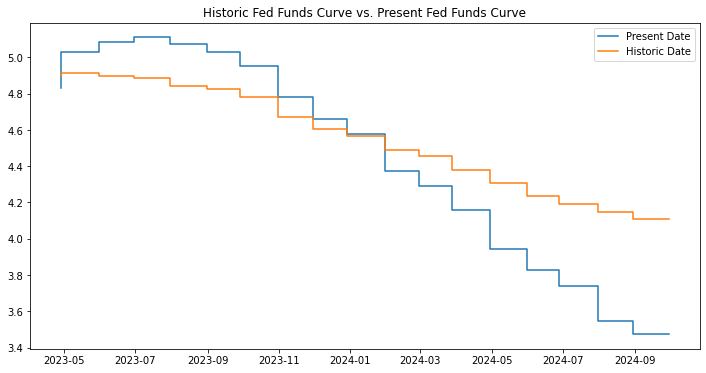

In [71]:
filepath = '../data/fedfutures_2023-04-21.xlsx'
fed_funds_present_data = pd.read_excel(filepath)

fed_funds_historic_data = pd.read_excel(filepath, sheet_name='fed futures historic')
# display(fed_funds_historic_data)

x = fed_funds_present_data['last_tradeable_dt']
y_1 = 100 - fed_funds_present_data['px_last']
y_2 = 100 - fed_funds_historic_data.iloc[:,1]

plt.step(x, y_1, label="Present Date")
plt.step(x, y_2, label="Historic Date")
plt.legend()
plt.title("Historic Fed Funds Curve vs. Present Fed Funds Curve")
plt.show()

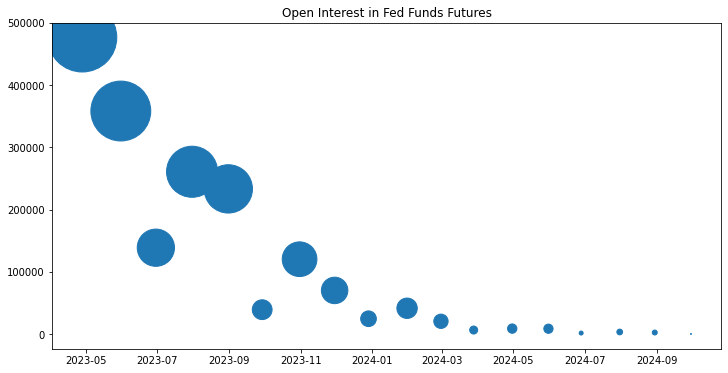

In [72]:
interest = fed_funds_present_data['open_int']

plt.scatter(x, interest, s=interest/100)
plt.title("Open Interest in Fed Funds Futures")
plt.show()

Looking at the scatter plot above, it's clear that most open interest in these futures is at the nearer expirations, with the most open interest clearly in the May future.

## 2.2 Extracting the Expected Path of Fed Funds Rates

The Fed has a great deal of control over the Fed Funds Rate. We simplify by assuming the Fed 
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Note
One (minor) assumption:
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.
* Here, use the simpler method #1--that is, for months with no meeting in the following month, the calculation is very simple.

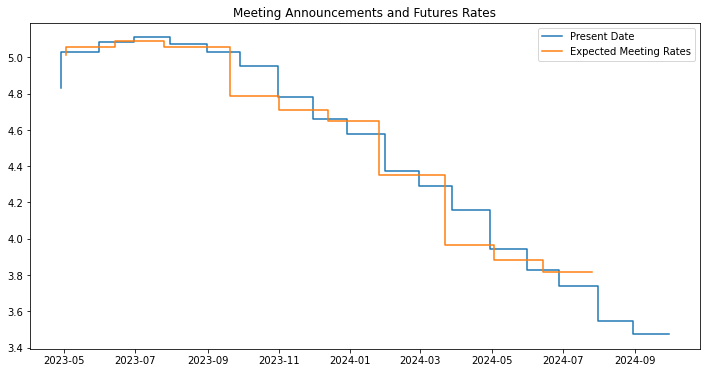

In [73]:
meeting_x = pd.read_excel(filepath, sheet_name='fed meetings')
rates = []

for date in meeting_x['meeting dates']:
    previous_month_rate = 100 - fed_funds_present_data[pd.to_datetime(fed_funds_present_data['last_tradeable_dt']) < pd.to_datetime(date)].iloc[-1]['px_last']
    next_month_rate = 100 - fed_funds_present_data[pd.to_datetime(fed_funds_present_data['last_tradeable_dt']) >= pd.to_datetime(date)].iloc[0]['px_last']
    day_of_month = pd.to_datetime(date).day
    total_days = pd.to_datetime(date).days_in_month
    rate = day_of_month / total_days * previous_month_rate + (total_days - day_of_month)/total_days * next_month_rate
    rates.append(rate)

plt.step(x, y_1, label="Present Date")
plt.step(meeting_x, rates, label="Expected Meeting Rates")
plt.legend()
plt.title("Meeting Announcements and Futures Rates")
plt.show()

## 2.3 Compare to the Historic Curve

Use the price data in the historic tab to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 
* There was no meeting in the current month, so its futures price is enough to get started.

Compare this to the answer in the previous problem, for the current data.

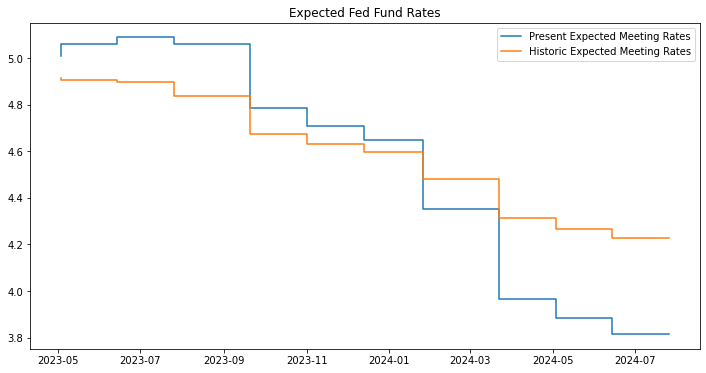

In [74]:
historic_expected_rates = []

for date in meeting_x['meeting dates']:
    previous_month_rate = 100 - fed_funds_historic_data[pd.to_datetime(fed_funds_present_data['last_tradeable_dt']) < pd.to_datetime(date)].iloc[-1,1]
    
    next_month_rate = 100 - fed_funds_historic_data[pd.to_datetime(fed_funds_present_data['last_tradeable_dt']) >= pd.to_datetime(date)].iloc[0,1]
    day_of_month = pd.to_datetime(date).day
    total_days = pd.to_datetime(date).days_in_month
    rate = day_of_month / total_days * previous_month_rate + (total_days - day_of_month)/total_days * next_month_rate
    historic_expected_rates.append(rate)

plt.step(meeting_x, rates, label="Present Expected Meeting Rates")
plt.step(meeting_x, historic_expected_rates, label="Historic Expected Meeting Rates")
plt.legend()
plt.title("Expected Fed Fund Rates")
plt.show()

It's interesting to not that historic estimations were less volatile that present expectations. We saw this in the futures data as well, which makes sense, as these meeting announced rates are extrapolated from the futures rates.

## 2.4 Analyzing the Expected Path

These questions are both conceptual--no calculation required.

### 2.4.1
Conceptually, is the path extracted above the **expected path**? In what sense is it or is it not?

It is, in the sense that it is based off of Fed Fund Futures rates, which themselves are market expectations of where the Fed Funds rate is going. However, they are extrapolated because of the futures inherently assume that the Fed Funds rate is directly influenced by these meeting announcements.

### 2.4.2

Probability Distributions

The implied path above is not representative of any single actual path of Fed rates, which are typically changed by 25bps at a time.

Conceptually, what would you need to make probability statements about the Fed moving rates up/down by 25bps on any given meeting date? For instance, as seen in the `probabilities` tab of the [CME FedWatch Tool](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html)?

Do not quantitatively solve this--just a conceptual answer is fine.

In order to make probability statements about the Fed Funds Rate moving, we would need the prices of options on these futures. That would allow us understand expectations of different paths and construct a tree with probabilities at each node accordingly.

***